In [57]:
from functools import reduce
from operator import add

import numpy as np
import torch
from torch import nn

## Transposed Convolution

Convolutional and pooling layers typically reduce (downsample) the spatial dimensions (height and width) of the input, or keep them unchanged. Sometimes we wish to accomplish the opposite. For instance, in semantic segmentation, we seek to classify at the pixel-level, where it will be convenient if the spatial dimensions of the input and output are the same. We can increase (upsample) the spatial dimensions of intermediate feature maps using the **transposed convolution**, which reverses the downsampling effects of the convolution operations. 

### Basic Operation

For now, we make the following simplifications: single-channel, stride of 1, and no padding. Suppose we have a rank-two input tensor that is 

$$n_h \times n_w$$

and a kernel that is 

$$k_h \times k_w$$

The output dimensions of the **transposed convolution** are given as:

$$
o_{h}=\frac{n_h+k_h+p_{\text {start }}+p_{\text{end}}}{s}-1=o_{h}=\frac{n_h+k_h+0+0}{s}-1=n_h+k_h-1
$$

and 

$$
o_{w}=\frac{n_w+k_w+p_{\text {start }}+p_{\text{end}}}{s}-1=o_{w}=\frac{n_w+k_w+0+0}{s}-1=n_w+k_w-1
$$

Note that this mirrors closely the output sizes for the *convolution* operation, which results in features maps of the size $(n_w-k_w+1) \times (n_w-k_w+1)$.

#### Example 1

<center>

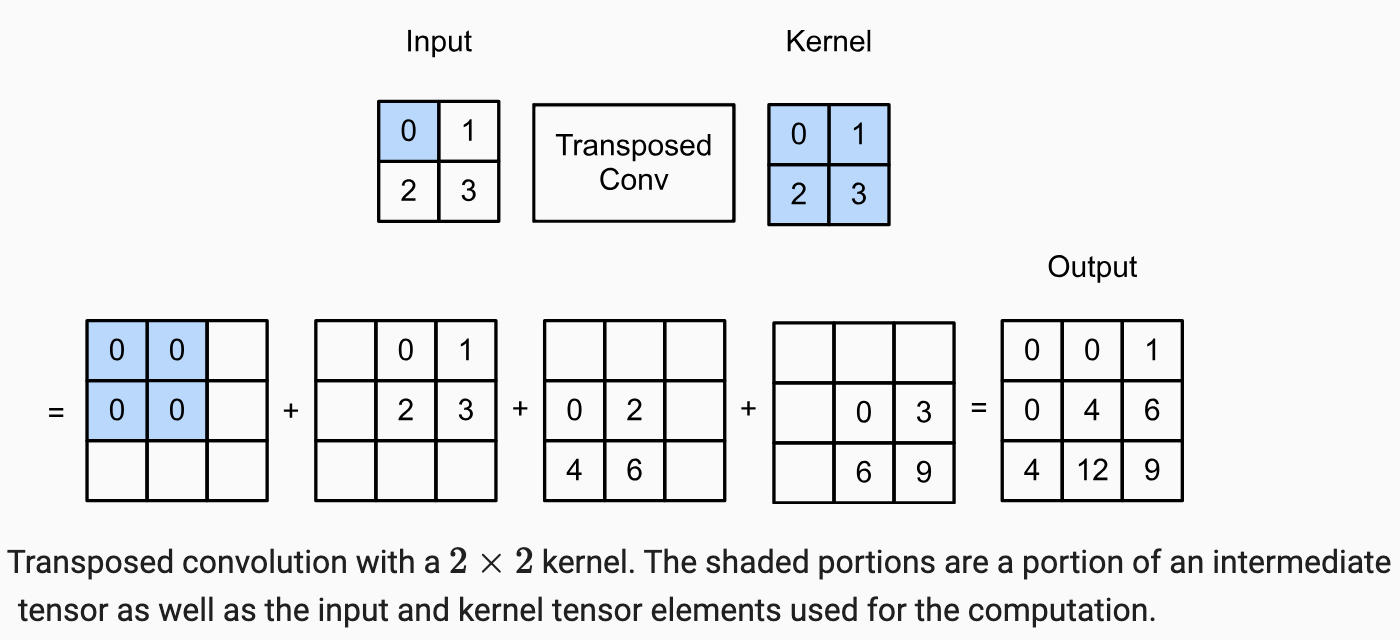

</center>

The computations are as follows:

In [34]:
input = np.array([[0, 1], [2, 3]])
kernel = np.copy(input)

intermediate_tensor_1 = input[0, 0] * kernel
intermediate_tensor_2 = input[0, 1] * kernel
intermediate_tensor_3 = input[1, 0] * kernel
intermediate_tensor_4 = input[1, 1] * kernel

# Padding to make the intermediate tensors the same size (before_i, after_i)
intermediate_tensor_1 = np.pad(intermediate_tensor_1, pad_width=((0, 1), (0, 1)))
intermediate_tensor_2 = np.pad(intermediate_tensor_2, pad_width=((0, 1), (1, 0)))
intermediate_tensor_3 = np.pad(intermediate_tensor_3, pad_width=((1, 0), (0, 1)))
intermediate_tensor_4 = np.pad(intermediate_tensor_4, pad_width=((1, 0), (1, 0)))
intermediate_tensors = [
    intermediate_tensor_1,
    intermediate_tensor_2,
    intermediate_tensor_3,
    intermediate_tensor_4,
]

for i in intermediate_tensors:
    print(i, "\n")

[[0 0 0]
 [0 0 0]
 [0 0 0]] 

[[0 0 1]
 [0 2 3]
 [0 0 0]] 

[[0 0 0]
 [0 2 0]
 [4 6 0]] 

[[0 0 0]
 [0 0 3]
 [0 6 9]] 



In [36]:
reduce(add, intermediate_tensors)

array([[ 0,  0,  1],
       [ 0,  4,  6],
       [ 4, 12,  9]])

#### Naive Implementation

In [3]:
def trans_conv(X: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
    """
    This function performs a 2D transposed convolution on the input tensor X and the kernel K.

    Parameters
    ----------
    X : torch.Tensor
        The input tensor of shape (n_h, n_w)
    K : torch.Tensor
        The kernel tensor of shape (k_h, k_w)

    Returns
    -------
    Y : torch.Tensor
        The output tensor of shape (n_h + k_h - 1, n_w + k_w - 1)
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # X[i, j] is a scalar and K is a matrix, so X[i, j] is broadcasted to a matrix of the same shape as K before the element-wise multiplication
            Y[i : i + h, j : j + w] += X[i, j] * K
    return Y

#### Example 2

In [49]:
X = torch.rand(9, 9)
K = torch.rand(3, 3)

out = trans_conv(X, K)
out.shape

torch.Size([11, 11])

In [54]:
tconv = nn.ConvTranspose2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False
)
# Add batch and channel dimensions for X and K (pytorch uses NCHW format)
# Alternatively, we can use X.unsqueeze(0).unsqueeze(0) and K.unsqueeze(0).unsqueeze(0)
X = X.reshape(1, 1, 9, 9)
K = K.reshape(1, 1, 3, 3)

# Change the kernel to K
tconv.weight.data = K
pytorch_out = tconv(X).squeeze(0).squeeze(0)

torch.norm(out - pytorch_out).detach().numpy()

array(1.0402035e-06, dtype=float32)

### Padding, Strides, and Multi-Channel

####

In contrast to regular convolution operation where padding is applied to the input, transposed convolution operations apply padding to the output:

In [110]:
X = torch.rand(9, 9)
K = torch.rand(3, 3)

tconv = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=0, bias=False)
tconv.weight.data = K.reshape(1, 1, 3, 3)

print(f"No padding: {tconv(X.reshape(1, 1, 9, 9)).shape}")

No padding: torch.Size([1, 1, 11, 11])


In [111]:
tconv = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=1, bias=False)
tconv.weight.data = K.reshape(1, 1, 3, 3)

print(f"Padding size 1: {tconv(X.reshape(1, 1, 9, 9)).shape}")

Padding size 1: torch.Size([1, 1, 9, 9])


In [113]:
tconv = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=2, bias=False)
tconv.weight.data = K.reshape(1, 1, 3, 3)

print(f"Padding size 2: {tconv(X.reshape(1, 1, 9, 9)).shape}")

Padding size 2: torch.Size([1, 1, 7, 7])


In convolution operations, positive padding increases the sizes of the output spatial dimensions. In contrast, paddings in transposed convolutions decrease the spatial dimensions of the output by a factor of $2 \times p$.

#### Strides

Again, in the transposed convolution, strides are specified for intermediate results (thus output) rather than the input. The relationship is again flipped, where strides increase the height and width of the intermediate tensor, and hence the output tensor. This has the opposite effect of strides in regular convolution operation, which decrease the sizes of the feature maps.

<center>

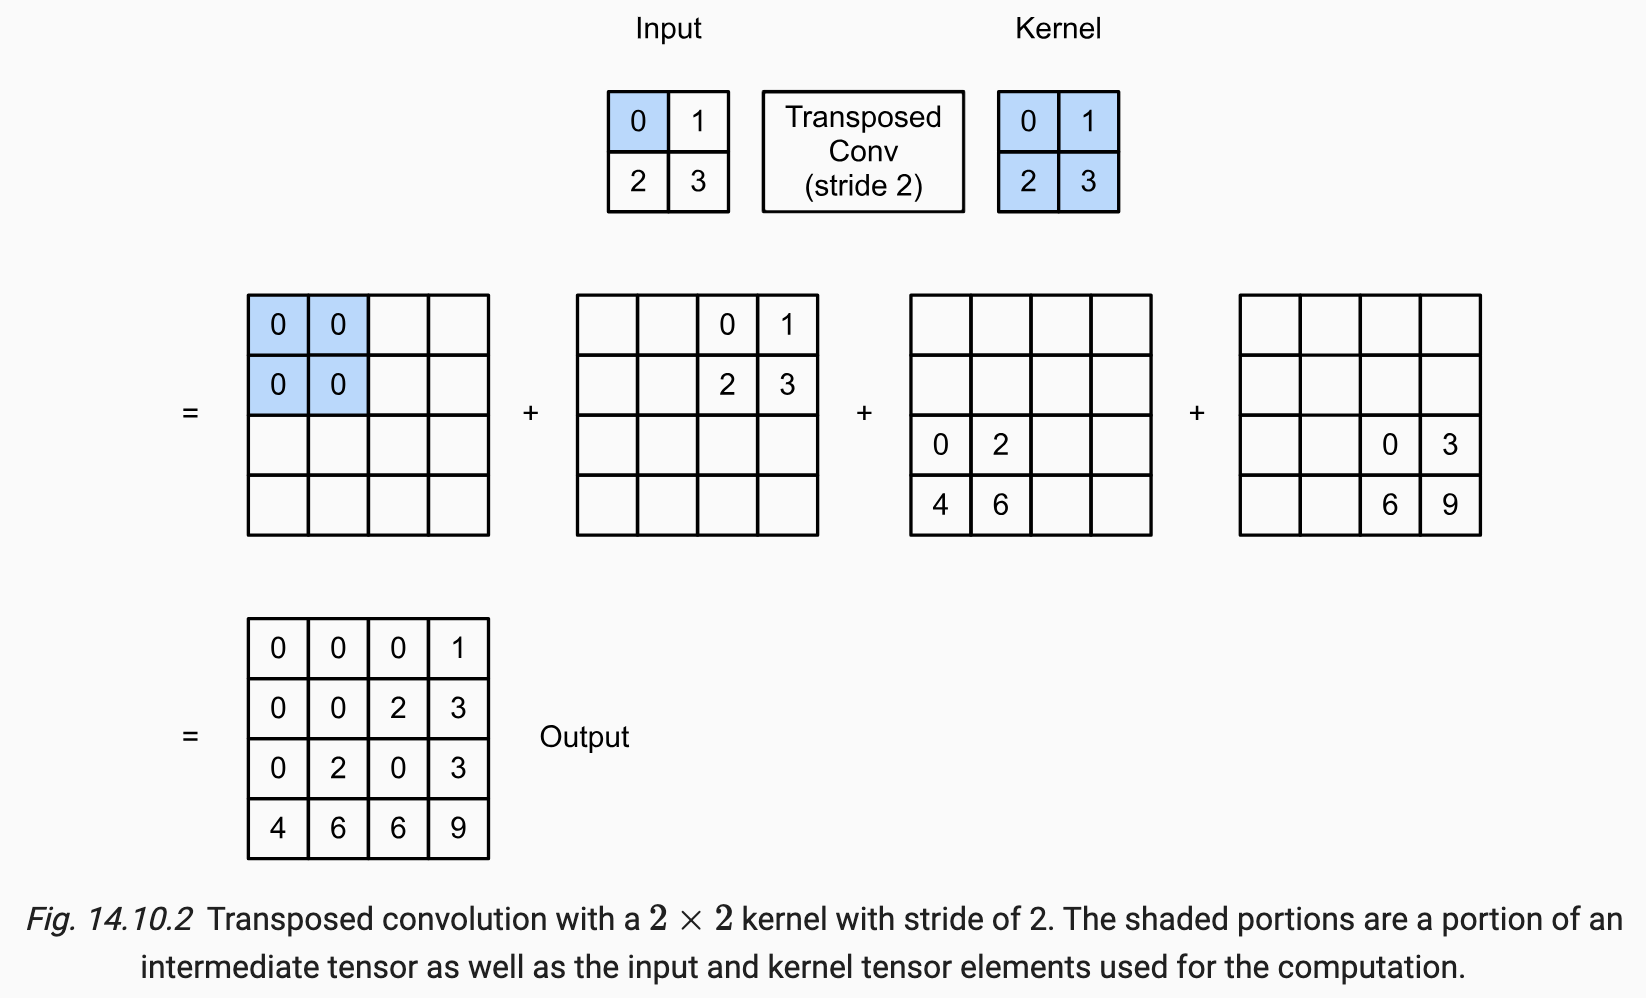

</center>

#### Multiple Channels

With multiple input and output channels, the transposed convolution works the same way as regular convolution.

In [114]:
# A minibatch of 10 images with 3 channels, height of 32 pixels, and width of 32 pixels
X = torch.rand(10, 3, 32, 32)
# Suppose we wish to have 16 output channels (feature maps) with stride 2 (increasing the spatial dimensions) and padding 1 (decreasing the spatial dimensions)
tconv = nn.ConvTranspose2d(3, 16, kernel_size=3, stride=2, padding=1)

tconv(X).shape

torch.Size([10, 16, 63, 63])

The formula for calculating the output spatial dimensions of a transposed convolution (deconvolution or upsampling):

Output Height $(H_{\text{out}}) = (H_{\text{in}} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1$

Output Width $(W_{\text{out}}) = (W_{\text{in}} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1$

where

- $H_{\text{in}}$ and $W_{\text{in}}$: Input spatial dimensions (height and width).
- $\text{stride}[0]$ and $\text{stride}[1]$: Stride values along the height and width dimensions, respectively.
- $\text{padding}[0]$ and $\text{padding}[1]$: Padding values along the height and width dimensions, respectively.
- $\text{dilation}[0]$ and $\text{dilation}[1]$: Dilation values along the height and width dimensions, respectively.
- $\text{kernel\_size}[0]$ and $\text{kernel\_size}[1]$: Kernel size along the height and width dimensions, respectively.
- $\text{output\_padding}[0]$ and $\text{output\_padding}[1]$: Additional padding values added to the output along the height and width dimensions, respectively.

The kernel for the transposed convolution works exactly like regular convolution:

$$W_{C_{in} \times C_{out} \times k_{h} \times k_{h}}$$

In [118]:
tconv.weight.shape

torch.Size([3, 16, 3, 3])

Note again that Pytoch uses a different format where the input and output channels come before the kernel height and width.